In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import mlflow

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Lancer MLFlow sur le port 5001 : mlflow ui --port 5001
mlflow.set_tracking_uri("http://127.0.0.1:5001")
mlflow.set_experiment("Monitoring des perf des modèles PCO")

<Experiment: artifact_location='mlflow-artifacts:/660506006876858877', creation_time=1730817563899, experiment_id='660506006876858877', last_update_time=1730817563899, lifecycle_stage='active', name='Monitoring des perf des modèles PCO', tags={}>

# Appel à l'API de la base de données pour récupérer les données de train mises à jour

# RFC 2

In [3]:
arr_algo_2 = np.load('array_algo_2.npy', allow_pickle=True)
arr_algo_2[0, 0:5]

array([8600432.0,
       'Vous travaillez sur des horaires en 3 8 du lundi au vendredi avec un roulement Matin / Après midi / Nuit',
       0, 0.5853265523910522, 0.09324663877487183], dtype=object)

In [4]:
df_algo_2 = pd.DataFrame(arr_algo_2)
nb_cat_bin = df_algo_2[2].value_counts()
nb_cat_bin

2
1    1300
0     566
Name: count, dtype: int64

## Préparation du dataset

In [5]:
X = arr_algo_2[:, 3:] # vecteurs d'embedding
Y = arr_algo_2[:, 2] # variable cible 0 / 1

In [6]:
X = X.astype(float)
Y = Y.astype(int)
print(X.dtype)
print(Y.dtype)

float64
int32


In [7]:
# seed random
import random

seed = random.randint(0, 1000)
print(f"Seed utilisée : {seed}")

Seed utilisée : 975


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=seed, stratify=Y)

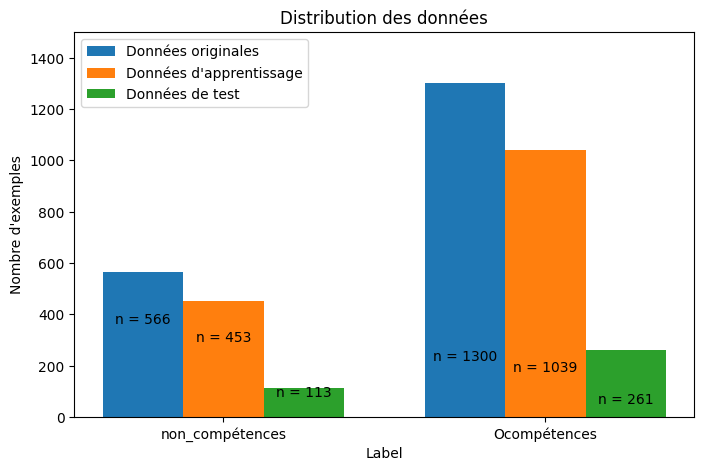

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5), dpi=100)

plt.title("Distribution des données")

plt.hist([Y, y_train, y_test],
         bins = [x - 0.5 for x in range(0, 3)],
         rwidth=0.75,
         label=["Données originales", "Données d'apprentissage", "Données de test"])

plt.annotate("n = " + str(np.sum(Y == 0)), (-0.25, 365.0), ha='center')
plt.annotate("n = " + str(np.sum(y_train == 0)), (0.0, 293.0), ha='center')
plt.annotate("n = " + str(np.sum(y_test == 0)), (0.25, 80.0), ha='center')

plt.annotate("n = " + str(np.sum(Y == 1)), (0.75, 220.0), ha='center')
plt.annotate("n = " + str(np.sum(y_train == 1)), (1.0, 178.0), ha='center')
plt.annotate("n = " + str(np.sum(y_test == 1)), (1.25, 50.0), ha='center')

plt.xticks(np.arange(2), ("non_compétences", "Ocompétences"))

plt.xlabel("Label")
plt.ylabel("Nombre d'exemples")

plt.ylim(0.0, 1500.0)

plt.legend()

plt.show()

## Recherche meilleurs hyperparamètres

In [10]:
from sklearn.ensemble import RandomForestClassifier

## Entrainement avec meilleurs hyperparamètres

In [11]:
from mlflow.models.signature import infer_signature

with mlflow.start_run(run_name="model_metrics_train_2") as run:
    best_n_estim = 500
    best_max_depth = 5

    # Définir et entraîner le modèle
    rfc = RandomForestClassifier(
        # class_weight='balanced',
        n_estimators=best_n_estim,
        max_depth=best_max_depth,
        bootstrap=True,
        random_state=seed,
        oob_score=True
    )

    rfc.fit(X_train, y_train)
    print(f"Erreur OOB : {1 - rfc.oob_score_}")

    y_pred = rfc.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)

    # Inférer la signature une fois le modèle entraîné
    X_train_df = pd.DataFrame(X_train)
    input_example = X_train_df.sample(1)  # Exemple d'entrée (une seule ligne)
    signature = infer_signature(X_train_df, rfc.predict(X_train))  # Signature

    # Logger les métriques
    mlflow.log_metric("accuracy_rfc_2", accuracy)
    mlflow.log_metric("precision_rfc_2", precision)
    mlflow.log_metric("recall_rfc_2", recall)
    mlflow.log_metric("f1_score_rfc_2", f1)

    # Logger les hyperparamètres
    mlflow.log_param("n_estimators_rfc_2", best_n_estim)
    mlflow.log_param("max_depth_rfc_2", best_max_depth)

    # Logger le modèle avec signature et exemple d'entrée
    mlflow.sklearn.log_model(
        rfc,
        "rfc_2",
        input_example=input_example,
        signature=signature
    )


Erreur OOB : 0.11729222520107241
Accuracy: 0.9037433155080213
Precision: 0.8839590443686007
Recall: 0.9923371647509579
F1-score: 0.9350180505415163


2024/11/17 11:37:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run model_metrics_train_2 at: http://127.0.0.1:5001/#/experiments/660506006876858877/runs/a022c3a186424fa4af7a7cf3c33c5559.
2024/11/17 11:37:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5001/#/experiments/660506006876858877.


## Prédictions jeu de train

## Prédictions jeu de test

In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_, normalize='true')

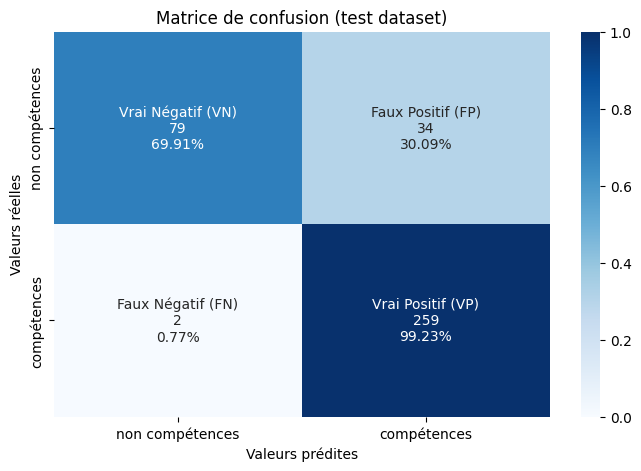

In [13]:
import seaborn as sns

names = ['Vrai Négatif (VN)', 'Faux Positif (FP)','Faux Négatif (FN)', 'Vrai Positif (VP)']
counts = ["{0:0.0f}\n".format(value) for value in confusion_matrix(y_test, y_pred, normalize=None).flatten()]
percentages = ["{0:.2%}".format(value) for value in confusion_matrix(y_test, y_pred, normalize='true').flatten()]

box_labels = [f"{v1}\n{v2}{v3}" for v1, v2, v3 in zip(names, counts, percentages)]
box_labels = np.asarray(box_labels).reshape(cm.shape[0],cm.shape[1])

plt.figure(figsize=(8,5), dpi=100)

plt.title("Matrice de confusion (test dataset)")

sns.heatmap(cm,
            vmin=0.0,
            vmax=1.0,
            cmap='Blues',
            annot=box_labels,
            fmt='',
            xticklabels=['non compétences', 'compétences'],
            yticklabels=['non compétences', 'compétences'])

plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")

plt.show()

# Observations mauvaises prédictions

In [14]:
df_train, df_test = train_test_split(df_algo_2, test_size=0.20, random_state=seed, stratify=Y)
df_test['true']=y_test
df_test['pred']=y_pred

In [15]:
# Faux négatifs
df_test.loc[(df_test['true'] == 1) & (df_test['pred'] == 0)]

,0,1,2,3,4,5,6,7,8,9,...,1019,1020,1021,1022,1023,1024,1025,1026,true,pred
387,1047194.0,travailler en horaires d' équipe 2 8,1,0.490331,-0.310272,-0.138178,0.461464,0.248946,-0.142413,0.018935,...,-0.050704,-0.256976,-0.072648,-0.258892,0.208211,-0.148366,-0.063595,-0.265734,1,0
17,9995742.0,souhaitez vous investir dans un poste qui vous,1,0.39181,-0.180326,-0.163289,0.309065,0.141705,0.155845,0.211607,...,-0.518919,-0.051876,-0.592389,-0.222556,-0.049542,0.310627,0.037517,-0.168729,1,0


In [16]:
# Faux positifs
df_test.loc[(df_test['true'] == 0) & (df_test['pred'] == 1)]

,0,1,2,3,4,5,6,7,8,9,...,1019,1020,1021,1022,1023,1024,1025,1026,true,pred
1305,9458332.0,recrute 1500 nouveaux collaborateurs en 2023,0,0.466942,-0.527145,0.427047,-0.057499,0.376234,0.234318,0.405976,...,0.476516,-0.168006,-0.548975,-0.366872,0.040202,-0.10841,-0.176192,-0.434105,0,1
1365,1515665.0,Issu de formation technique ou à l' aise avec les travaux de second œuvre vous,0,-0.277116,-0.349583,-0.471539,0.263925,0.006581,-0.164558,-0.069547,...,0.257592,0.191273,0.165245,-0.046179,0.362268,0.042155,0.544803,-0.241246,0,1
578,4997699.0,En tant que technicien de maintenance et sous la responsabilité du Responsable de Maintenance vous êtes amené à,0,0.249452,-0.548699,-0.421645,0.387397,0.132398,-0.392391,-0.331322,...,-0.637752,0.493293,-0.259591,-0.416708,-0.112289,0.031473,0.288824,-0.22109,0,1
1851,2658343.0,Rattaché au Responsable Maintenance vos journées seront,0,0.554239,-0.192181,-0.325974,0.557721,0.338348,-0.456705,-0.360111,...,-0.68151,0.439921,-0.403058,-0.339547,0.10269,-0.015555,0.438807,0.012393,0,1
354,5749339.0,Vous justifiez d' une expérience en tant que Chaudronnier / soudeur,0,0.379371,-0.099263,-0.416076,-0.233431,-0.126096,0.174889,-0.394543,...,-0.088294,0.042868,-0.079376,-0.091506,-0.100529,-0.005447,0.553197,-0.458795,0,1
1570,4624392.0,De formation maintenance,0,0.182744,-0.327153,-0.37435,0.550548,0.244299,-0.278597,-0.202017,...,-0.136878,0.416814,-0.307077,-0.590535,-0.358288,-0.464982,0.249326,0.179359,0,1
362,9552396.0,de nuit ( 21h00 6h00 ),0,0.023283,-0.064398,-0.538226,0.11726,-0.113022,0.260204,0.076753,...,-0.556767,-0.301268,0.05394,0.207941,0.172245,0.203034,0.434997,0.071422,0,1
424,7198371.0,ADEVA PONTIVY recherche des monteurs de charpente métalliques,0,0.678915,0.559453,-0.112209,-0.134271,-0.079546,-0.217847,-0.125254,...,-0.272716,-0.097415,-0.03207,-0.170515,0.001755,-0.269174,-0.203261,-0.175962,0,1
314,637372.0,avez impérativement une expérience en soudure et retouche CMS et traversant,0,0.158951,-0.356397,-0.355748,-0.396351,0.410039,-0.059032,-0.597726,...,0.532642,0.41501,-0.162488,0.204034,-0.08715,-0.354551,0.53338,-0.313884,0,1
1677,9427043.0,01/03/2023,0,0.700909,-0.226777,-0.0026,0.167536,0.689095,0.391634,0.276202,...,-0.058968,-0.119525,-0.326695,0.055283,-0.188351,-0.121948,0.311833,-0.051804,0,1


## Enregistrement du modèle

In [17]:
import joblib
from joblib import dump

#dump(rfc, 'rfc_2.joblib')